# Adversarial Attack Demo on MNIST Dataset

This demo is developed based on
Tricking Neural Networks: Create your own Adversarial Examples by Machine Learning@Berkley

In [1]:
%matplotlib inline
import network.network as Network
import network.mnist_loader as mnist_loader
import pickle
import matplotlib.pyplot as plt
import numpy as np

### Load the trained MNIST model

In [2]:
# with open('network/trained_network.pkl', 'rb') as f:
#     net = pickle.load(f)

# PYTHON 3 WORK AROUND (uncomment this
# and comment the above if using python 3)
with open('network/trained_network.pkl', 'rb') as f:
   u = pickle._Unpickler(f)
   u.encoding = 'latin1'
   net = u.load()
    
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

In [3]:
test_data = list(test_data)
training_data = list(training_data)
validation_data = list(validation_data)

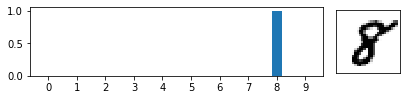

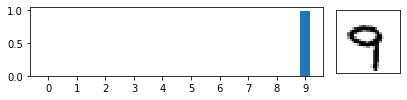

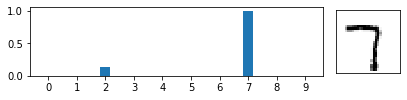

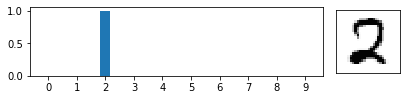

In [4]:
def predict(n):
    # Get the data from the test set
    x = test_data[n][0]

    pred = net.feedforward(x)
    # Print the prediction of the network
#     print('Network output: \n' + str(np.round(pred, 2)) + '\n')
    fig, ax = plt.subplots(figsize=(8,30))
    ax = plt.subplot2grid((20, 6), (0, 0), colspan=4)
    plt.bar(np.arange(10), net.feedforward(x).reshape(-1), 0.35, align='center')
    plt.xticks(np.arange(10), np.arange(10))
    ax = plt.subplot2grid((20, 6), (0, 4))
    plt.imshow(x.reshape((28,28)), cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    plt.show()
#     print('Network prediction: ' + str(np.argmax(pred)) + '\n')
#     print('Actual image: ')
    
    # Draw the image
#     plt.imshow(x.reshape((28,28)), cmap='Greys')

# Replace the argument with any number between 0 and 9999
predict(8384)
predict(4701)
predict(3192)
predict(4510)

### Non-Targeted Attack

In [5]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))
                                                                                                                                                                                
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [6]:
def input_derivative(net, x, y):
    """ Calculate derivatives wrt the inputs"""
    nabla_b = [np.zeros(b.shape) for b in net.biases]
    nabla_w = [np.zeros(w.shape) for w in net.weights]
    
    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(net.biases, net.weights):
        z = np.dot(w, activation)+b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
        
    # backward pass
    delta = net.cost_derivative(activations[-1], y) * \
        sigmoid_prime(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())

    for l in range(2, net.num_layers):
        z = zs[-l]
        sp = sigmoid_prime(z)
        delta = np.dot(net.weights[-l+1].transpose(), delta) * sp
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        
    # Return derivatives WRT to input
    return net.weights[0].T.dot(delta)

In [7]:
def adversarial(net, n, steps, eta):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    """
    # Set the goal output
    goal = np.zeros((10, 1))
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    x = np.random.normal(.5, .3, (784, 1))

    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        d = input_derivative(net,x,goal)
        
        # The GD update on x
        x -= eta * d
        
    return x

# Wrapper function
def generate(n):
    """
    n : integer
        goal label (not a one hot vector)
    """
    a = adversarial(net, n, 1000, 1)
    x = np.round(net.feedforward(a), 2)
    
#     print('Network Output: \n' + str(x) + '\n')
    
#     print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    
#     print('Adversarial Example: ')
#     plt.imshow(a.reshape(28,28), cmap='Greys')
    pred = net.feedforward(a)
    # Print the prediction of the network
#     print('Network output: \n' + str(np.round(pred, 2)) + '\n')
    fig, ax = plt.subplots(figsize=(8,30))
    ax = plt.subplot2grid((20, 6), (0, 0), colspan=4)
    plt.bar(np.arange(10), net.feedforward(a).reshape(-1), 0.35, align='center')
    plt.xticks(np.arange(10), np.arange(10))
    ax = plt.subplot2grid((20, 6), (0, 4))
    plt.imshow(a.reshape((28,28)), cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    plt.show()

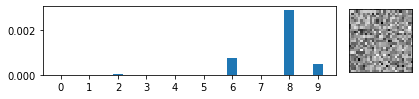

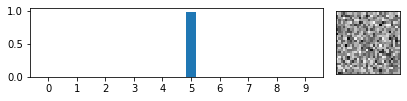

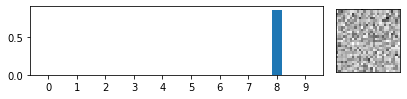

In [8]:
generate(3)
generate(5)
generate(8)

### Targeted Attack

In [9]:
def sneaky_adversarial(net, n, x_target, steps, eta, lam=.05):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    x_target : numpy vector
        our goal image for the adversarial example
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    lam : float
        lambda, our regularization parameter. Default is .05
    """
    
    # Set the goal output
    goal = np.zeros((10, 1))
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    x = np.random.normal(.5, .3, (784, 1))

    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        d = input_derivative(net,x,goal)
        
        # The GD update on x, with an added penalty to the cost function
        # ONLY CHANGE IS RIGHT HERE!!!
        x -= eta * (d + lam * (x - x_target))

    return x

# Wrapper function
def sneaky_generate(n, m):
    """
    n: int 0-9, the target number to match
    m: index of example image to use (from the test set)
    """
    
    # Find random instance of m in test set
    idx = np.random.randint(0,8000)
    while test_data[idx][1] != m:
        idx += 1
    
    # Hardcode the parameters for the wrapper function
    a = sneaky_adversarial(net, n, test_data[idx][0], 100, 1)
    x = np.round(net.feedforward(a), 2)
    
#     print('\nWhat we want our adversarial example to look like: ')
#     plt.imshow(test_data[idx][0].reshape((28,28)), cmap='Greys')
#     plt.show()
    
#     print('\n')
    
#     print('Adversarial Example: ')
    
#     plt.imshow(a.reshape(28,28), cmap='Greys')
#     plt.show()
    
#     print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    
#     print('Network Output: \n' + str(x) + '\n')
    
    pred = net.feedforward(a)
    # Print the prediction of the network
#     print('Network output: \n' + str(np.round(pred, 2)) + '\n')
    fig, ax = plt.subplots(figsize=(8,30))
    ax = plt.subplot2grid((20, 6), (0, 0), colspan=4)
    plt.bar(np.arange(10), net.feedforward(a).reshape(-1), 0.35, align='center')
    plt.xticks(np.arange(10), np.arange(10))
    ax = plt.subplot2grid((20, 6), (0, 4))
    plt.imshow(a.reshape((28,28)), cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return a

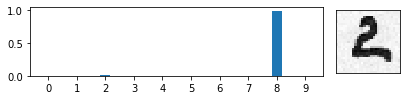

In [10]:
# sneaky_generate(target label, target digit)
adv_ex = sneaky_generate(8, 2)

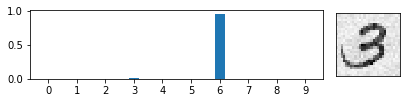

In [11]:
adv_ex = sneaky_generate(6, 3)

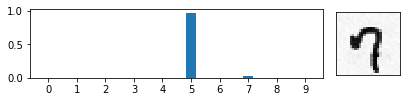

In [12]:
adv_ex = sneaky_generate(5, 7)